# 📊 Stock Price Analysis, Screening & Forecasting — Project Overview

##  Objective
This project combines **technical indicator screening** with **time series forecasting** to:
1. Classify stocks into **BUY / SELL / HOLD** for swing trading.
2. Predict future stock prices  and ROI(%) using statistical and deep learning models.

---

##  Methodology

### 1. **Technical Indicator Voting System**
- **Data:** Daily Close prices for multiple tickers.
- **Indicators:** SMA(20>50), EMA(12>26), RSI, MACD, Bollinger Bands, Momentum, ATR Breakout, Stochastic, CCI.
- **Voting:** Each strategy casts a BUY or SELL vote; decisions made by threshold:
  - BUY if `BUY_Votes ≥ min_buy_votes`
  - SELL if `SELL_Votes ≥ min_sell_votes`
  - Otherwise HOLD.
- **Output:** Latest-day classification table & decision counts.

### 2. **Time Series Analysis & Forecasting**
- **Models Used:** ARIMA/SARIMA, Facebook Prophet, LSTM.
- **Steps:**
  - Stationarity check (ADF test).
  - Trend/seasonality analysis.
  - Model training & validation.
  - Next N-day forecast generation.
- **Evaluation Metrics:** RMSE, MAPE, MAE.
- **Output:** Historical vs predicted price charts.

---

## Key Insights
- Ensemble voting from diverse indicators reduces false signals.
- ARIMA works well for short-term linear patterns.
- Prophet captures seasonal effects effectively.
- LSTM handles nonlinear relationships in price data.
- Combining forecasts with indicator signals could improve swing trade timing.

---

## Outputs
- **Tables:** `voting_summary.csv` / `.xlsx` with votes, counts, and decisions.
- **Forecast Plots:** Side-by-side actual vs predicted prices.
- **Metrics:** Accuracy scores for each forecasting model.


In [1125]:
# Import necessary libraries for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from prophet import Prophet
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from scipy.stats import ttest_ind, f_oneway
from tensorflow.keras.callbacks import EarlyStopping
from math import sqrt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

warnings.filterwarnings('ignore')


In [1126]:
Stockname = [
    "ACMESOLAR.NS", "AADHARHFC.NS", "AARTIIND.NS", "AAVAS.NS", "ACE.NS",
    "ABREL.NS", "ABSLAMC.NS", "AEGISLOG.NS", "AFCONS.NS", "AFFLE.NS",
    "AKUMS.NS", "APLLTD.NS", "ALIVUS.NS", "ALKYLAMINE.NS", "ALOKINDS.NS",
    "ARE&M.NS", "AMBER.NS", "ANANDRATHI.NS", "ANANTRAJ.NS", "ANGELONE.NS",
    "APTUS.NS", "ASAHIINDIA.NS", "ASTERDM.NS", "ASTRAZEN.NS", "ATUL.NS",
    "AIIL.NS", "BASF.NS", "BEML.NS", "BLS.NS", "BALRAMCHIN.NS",
    "BATAINDIA.NS", "BAYERCROP.NS", "BIKAJI.NS", "BSOFT.NS", "BLUEDART.NS",
    "BBTC.NS", "FIRSTCRY.NS", "BRIGADE.NS", "MAPMYINDIA.NS", "CCL.NS",
    "CESC.NS", "CAMPUS.NS", "CANFINHOME.NS", "CAPLIPOINT.NS", "CGCL.NS",
    "CARBORUNIV.NS", "CASTROLIND.NS", "CEATLTD.NS", "CENTRALBK.NS", "CDSL.NS",
    "CENTURYPLY.NS", "CERA.NS", "CHALET.NS", "CHAMBLFERT.NS", "CHENNPETRO.NS",
    "CHOLAHLDNG.NS", "CUB.NS", "CLEAN.NS", "CAMS.NS", "CONCORDBIO.NS",
    "CRAFTSMAN.NS", "CREDITACC.NS", "CROMPTON.NS", "CYIENT.NS", "DCMSHRIRAM.NS",
    "DOMS.NS", "DATAPATTNS.NS", "DEEPAKFERT.NS", "DELHIVERY.NS", "DEVYANI.NS",
    "LALPATHLAB.NS", "EIDPARRY.NS", "EIHOTEL.NS", "ELECON.NS", "ELGIEQUIP.NS",
    "EMCURE.NS", "ENGINERSIN.NS", "ERIS.NS", "FACT.NS", "FINCABLES.NS",
    "FINPIPE.NS", "FSL.NS", "FIVESTAR.NS", "GRSE.NS", "GILLETTE.NS",
    "GODIGIT.NS", "GPIL.NS", "GODFRYPHLP.NS", "GODREJAGRO.NS", "GRANULES.NS",
    "GRAPHITE.NS", "GRAVITA.NS", "GESHIP.NS", "GMDCLTD.NS", "GNFC.NS",
    "GPPL.NS", "GSPL.NS", "HEG.NS", "HBLENGINE.NS", "HFCL.NS",
    "HAPPSTMNDS.NS", "HSCL.NS", "HINDCOPPER.NS", "HOMEFIRST.NS", "HONASA.NS",
    "IDBI.NS", "IFCI.NS", "IIFL.NS", "INOXINDIA.NS", "IRCON.NS",
    "ITI.NS", "INDGN.NS", "INDIACEM.NS", "INDIAMART.NS", "IEX.NS",
    "IOB.NS", "INOXWIND.NS", "INTELLECT.NS", "IGIL.NS", "IKS.NS",
    "JBCHEPHARM.NS", "JBMA.NS", "JKTYRE.NS", "JMFINANCIL.NS", "JSWHL.NS",
    "JPPOWER.NS", "J&KBANK.NS", "JINDALSAW.NS", "JUBLINGREA.NS", "JUBLPHARMA.NS",
    "JWL.NS", "JUSTDIAL.NS", "JYOTHYLAB.NS", "JYOTICNC.NS", "KNRCON.NS",
    "KAJARIACER.NS", "KPIL.NS", "KANSAINER.NS", "KARURVYSYA.NS", "KAYNES.NS",
    "KEC.NS", "KFINTECH.NS", "KIRLOSBROS.NS", "KIRLOSENG.NS", "KIMS.NS",
    "LTFOODS.NS", "LATENTVIEW.NS", "LAURUSLABS.NS", "LEMONTREE.NS", "MMTC.NS",
    "MGL.NS", "MAHSEAMLES.NS", "MANAPPURAM.NS", "MASTEK.NS", "METROPOLIS.NS",
    "MINDACORP.NS", "MCX.NS", "NATCOPHARM.NS", "NBCC.NS", "NCC.NS",
    "NSLNISP.NS", "NH.NS", "NAVA.NS", "NAVINFLUOR.NS", "NETWEB.NS",
    "NETWORK18.NS", "NEULANDLAB.NS", "NEWGEN.NS", "NIVABUPA.NS", "NUVAMA.NS",
    "OLECTRA.NS", "PCBL.NS", "PGEL.NS", "PNBHOUSING.NS", "PNCINFRA.NS",
    "PTCIL.NS", "PVRINOX.NS", "PFIZER.NS", "PEL.NS", "PPLPHARMA.NS",
    "POLYMED.NS", "POONAWALLA.NS", "PRAJIND.NS", "RRKABEL.NS", "RBLBANK.NS",
    "RHIM.NS", "RITES.NS", "RADICO.NS", "RAILTEL.NS", "RAINBOW.NS",
    "RKFORGE.NS", "RCF.NS", "RTNINDIA.NS", "RAYMONDLSL.NS", "RAYMOND.NS",
    "REDINGTON.NS", "RPOWER.NS", "ROUTE.NS", "SBFC.NS", "SKFINDIA.NS",
    "SAGILITY.NS", "SAILIFE.NS", "SAMMAANCAP.NS", "SAPPHIRE.NS", "SARDAEN.NS",
    "SAREGAMA.NS", "SCHNEIDER.NS", "SCI.NS", "RENUKA.NS", "SHYAMMETL.NS",
    "SIGNATURE.NS", "SOBHA.NS", "SONATSOFTW.NS", "SWSOLAR.NS", "SUMICHEM.NS",
    "SUNDRMFAST.NS", "SWANENERGY.NS", "SYRMA.NS", "TBOTEK.NS", "TANLA.NS",
    "TATACHEM.NS", "TTML.NS", "TECHNOE.NS", "TEJASNET.NS", "RAMCOCEM.NS",
    "TIMKEN.NS", "TITAGARH.NS", "TARIL.NS", "TRIDENT.NS", "TRIVENI.NS",
    "TRITURBINE.NS", "UCOBANK.NS", "UTIAMC.NS", "USHAMART.NS", "VGUARD.NS",
    "DBREALTY.NS", "VTL.NS", "MANYAVAR.NS", "VIJAYA.NS", "WELCORP.NS",
    "WELSPUNLIV.NS", "WESTLIFE.NS", "WHIRLPOOL.NS", "WOCKPHARMA.NS", "ZFCVINDIA.NS","ZEEL.NS", "ZENTEC.NS", "ZENSARTECH.NS", "ECLERX.NS"

]


In [1049]:
import yfinance as yf

start ="2023-01-01"
end =  "2025-07-06"

ticker = Stockname

# Get data from January 1, 2023 to the present
df1 = yf.download(ticker, start= start,end= end)


[*********************100%***********************]  249 of 249 completed


In [1050]:
# print the df1
df1.head()

Price             Close                                                   \
Ticker     AADHARHFC.NS AARTIIND.NS     AAVAS.NS    ABREL.NS  ABSLAMC.NS   
Date                                                                       
2023-01-02          NaN  606.798462  1808.199951  720.977539  424.319214   
2023-01-03          NaN  612.759155  1798.050049  720.580933  425.480682   
2023-01-04          NaN  603.917480  1761.650024  707.789551  425.294891   
2023-01-05          NaN  602.427368  1731.650024  712.945740  417.907715   
2023-01-06          NaN  595.125427  1746.800049  703.773682  416.839111   

Price                                                                   ...  \
Ticker          ACE.NS ACMESOLAR.NS AEGISLOG.NS AFCONS.NS     AFFLE.NS  ...   
Date                                                                    ...   
2023-01-02  305.322144          NaN         NaN       NaN  1072.050049  ...   
2023-01-03  309.302246          NaN         NaN       NaN  1072.050049  ...   
2023-01-04  315.819611          NaN         NaN       NaN  1043.650024  ...   
2023-01-05  315.869385          NaN         NaN       NaN  1037.000000  ...   
2023-01-06  310.745026          NaN         NaN       NaN  1055.300049  ...   

Price       Volume                                                    \
Ticker      VTL.NS WELCORP.NS WELSPUNLIV.NS WESTLIFE.NS WHIRLPOOL.NS   
Date                                                                   
2023-01-02  198503     718068        385089      106897        31344   
2023-01-03  411685     425245        412569       84533       133936   
2023-01-04  100639     371051        431783      110684        29598   
2023-01-05  223810     340164        688184      136885        66598   
2023-01-06  169186     675198       1465072       64941        39352   

Price                                                                   
Ticker     WOCKPHARMA.NS  ZEEL.NS ZENSARTECH.NS ZENTEC.NS ZFCVINDIA.NS  
Date                                                                    
2023-01-02        532908  3713958        323167     98722         8267  
2023-01-03       2080686  5316536        533417    115136         3658  
2023-01-04       3053680  4968528        405826   1725838         3906  
2023-01-05       1141257  4488552       1329676    645346         7991  
2023-01-06       1043241  1836104        528468    168397         2746  

[5 rows x 1245 columns]

In [1051]:
# shape of the df1
df1.shape

(618, 1245)

In [1052]:
# store   only close price data  of each stocks :
df= df1['Close']

In [1053]:
df.head()

Ticker,AADHARHFC.NS,AARTIIND.NS,AAVAS.NS,ABREL.NS,ABSLAMC.NS,ACE.NS,ACMESOLAR.NS,AEGISLOG.NS,AFCONS.NS,AFFLE.NS,...,VTL.NS,WELCORP.NS,WELSPUNLIV.NS,WESTLIFE.NS,WHIRLPOOL.NS,WOCKPHARMA.NS,ZEEL.NS,ZENSARTECH.NS,ZENTEC.NS,ZFCVINDIA.NS
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-02,NaN,606.798462,1808.199951,720.977539,424.319214,305.322144,NaN,NaN,NaN,1072.050049,...,320.017609,229.456329,75.756325,770.237854,1487.665771,223.899994,241.153809,205.687012,186.829788,8869.830078
2023-01-03,NaN,612.759155,1798.050049,720.580933,425.480682,309.302246,NaN,NaN,NaN,1072.050049,...,318.150177,225.877884,75.509712,759.837341,1507.006714,229.100006,238.177826,206.837708,187.528198,8926.227539
2023-01-04,NaN,603.917480,1761.650024,707.789551,425.294891,315.819611,NaN,NaN,NaN,1043.650024,...,315.496460,221.138855,74.227379,759.389404,1497.311279,232.199997,235.053040,204.536331,197.755188,9002.305664
2023-01-05,NaN,602.427368,1731.650024,712.945740,417.907715,315.869385,NaN,NaN,NaN,1037.000000,...,308.616486,218.962753,72.994370,769.143005,1503.675415,235.000000,237.830627,201.419861,198.902634,9053.423828
2023-01-06,NaN,595.125427,1746.800049,703.773682,416.839111,310.745026,NaN,NaN,NaN,1055.300049,...,304.439362,211.564056,71.169510,765.560120,1492.587891,229.000000,235.896240,200.173264,194.063492,9101.204102


In [1054]:
# =========================
# STRATEGY DEFINITIONS (BUY/SELL)
# =========================

def strategy_sma_cross(close):
    sma9 = close.rolling(window=9).mean()
    sma20 = close.rolling(window=20).mean()
    return np.where(sma9 > sma20, "BUY", "SELL")

def strategy_ema_cross(close):
    ema12 = close.ewm(span=12, adjust=False).mean()
    ema26 = close.ewm(span=26, adjust=False).mean()
    return np.where(ema12 > ema26, "BUY", "SELL")

def strategy_rsi(close):
    delta = close.diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return np.where(rsi < 30, "BUY", "SELL")

def strategy_macd(close):
    ema12 = close.ewm(span=12, adjust=False).mean()
    ema26 = close.ewm(span=26, adjust=False).mean()
    macd = ema12 - ema26
    signal = macd.ewm(span=9, adjust=False).mean()
    return np.where(macd > signal, "BUY", "SELL")

def strategy_bollinger(close):
    sma20 = close.rolling(window=20).mean()
    stddev = close.rolling(window=20).std()
    lower_band = sma20 - (2 * stddev)
    return np.where(close <= lower_band, "BUY", "SELL")

def strategy_momentum(close):
    momentum = close - close.shift(10)
    return np.where(momentum > 0, "BUY", "SELL")

def strategy_atr_breakout(close):
    tr = (close - close.shift(1)).abs()
    atr = tr.rolling(window=14).mean()
    upper_break = close.shift(1) + (2 * atr)
    return np.where(close > upper_break, "BUY", "SELL")

def strategy_stochastic(close, k_window=14, d_window=3):
    low_min = close.rolling(window=k_window).min()
    high_max = close.rolling(window=k_window).max()
    k_percent = 100 * (close - low_min) / (high_max - low_min)
    return np.where(k_percent < 25, "BUY", "SELL")

def strategy_cci(close, n=20):
    sma = close.rolling(window=n).mean()
    mad = close.rolling(window=n).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    cci = (close - sma) / (0.015 * mad)
    return np.where(cci < -80, "BUY", "SELL")

In [1055]:
# =========================
# STRATEGY LIST
# =========================
strategies = [
    strategy_sma_cross,
    strategy_ema_cross,
    strategy_rsi,
    strategy_macd,
    strategy_bollinger,
    strategy_momentum,
    strategy_atr_breakout,
    strategy_stochastic,
    strategy_cci
]

In [1056]:
# =========================
# VOTING SYSTEM (BUY/SELL/HOLD)
# =========================
from collections import Counter

buy_stocks = []
sell_stocks = []
hold_stocks = []

# ---- Manual condition settings ----
min_buy_votes = 8
min_sell_votes = 8

for ticker in df.columns:
    close_prices = df[ticker]
    votes = []

    for strat in strategies:
        signals = strat(close_prices)
        votes.append(signals[-1])  # last day's vote

    vote_counts = Counter(votes)
    buy_votes = vote_counts.get("BUY", 0)
    sell_votes = vote_counts.get("SELL", 0)

     # ---- Apply manual conditions ----
    if buy_votes >= min_buy_votes:
        buy_stocks.append(ticker)
    elif sell_votes >= min_sell_votes:
        sell_stocks.append(ticker)
    else:
        hold_stocks.append(ticker)

In [1057]:
# =========================
# RESULTS
# =========================
print("BUY stocks:", buy_stocks)
print("SELL stocks:", sell_stocks)
print("HOLD stocks:", hold_stocks)

BUY stocks: []
SELL stocks: ['ACE.NS', 'ARE&M.NS', 'CAPLIPOINT.NS', 'CYIENT.NS', 'ELECON.NS', 'FSL.NS', 'GRANULES.NS', 'JWL.NS', 'LALPATHLAB.NS', 'MINDACORP.NS', 'NCC.NS', 'NEULANDLAB.NS', 'RADICO.NS', 'RAILTEL.NS', 'WOCKPHARMA.NS']
HOLD stocks: ['AADHARHFC.NS', 'AARTIIND.NS', 'AAVAS.NS', 'ABREL.NS', 'ABSLAMC.NS', 'ACMESOLAR.NS', 'AEGISLOG.NS', 'AFCONS.NS', 'AFFLE.NS', 'AIIL.NS', 'AKUMS.NS', 'ALIVUS.NS', 'ALKYLAMINE.NS', 'ALOKINDS.NS', 'AMBER.NS', 'ANANDRATHI.NS', 'ANANTRAJ.NS', 'ANGELONE.NS', 'APLLTD.NS', 'APTUS.NS', 'ASAHIINDIA.NS', 'ASTERDM.NS', 'ASTRAZEN.NS', 'ATUL.NS', 'BALRAMCHIN.NS', 'BASF.NS', 'BATAINDIA.NS', 'BAYERCROP.NS', 'BBTC.NS', 'BEML.NS', 'BIKAJI.NS', 'BLS.NS', 'BLUEDART.NS', 'BRIGADE.NS', 'BSOFT.NS', 'CAMPUS.NS', 'CAMS.NS', 'CANFINHOME.NS', 'CARBORUNIV.NS', 'CASTROLIND.NS', 'CCL.NS', 'CDSL.NS', 'CEATLTD.NS', 'CENTRALBK.NS', 'CENTURYPLY.NS', 'CERA.NS', 'CESC.NS', 'CGCL.NS', 'CHALET.NS', 'CHAMBLFERT.NS', 'CHENNPETRO.NS', 'CHOLAHLDNG.NS', 'CLEAN.NS', 'CONCORDBIO.NS', 'CRA

In [1058]:
# Now Start the main project

In [1059]:
# download the stocks data for a perticular stock
import yfinance as yf
stock = ['CERA.NS']

# Get data
df2 = yf.download(stock, start= start, end= end)

df2.head()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,CERA.NS,CERA.NS,CERA.NS,CERA.NS,CERA.NS
Date,,,,,
2023-01-02,5196.901367,5229.462786,5083.766694,5091.833760,6091
2023-01-03,5155.050781,5202.670628,5123.760344,5202.035137,4068
2023-01-04,5117.453125,5182.185407,5060.983665,5182.185407,7281
2023-01-05,5147.375000,5210.004577,5088.509672,5104.301469,6642
2023-01-06,5178.519043,5261.682973,5090.563382,5090.563382,7457


In [1060]:
# rename columns
df2 = df2.reset_index()
df2.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
print(df2.head())

        Date         Open         High          Low        Close  Volume
0 2023-01-02  5196.901367  5229.462786  5083.766694  5091.833760    6091
1 2023-01-03  5155.050781  5202.670628  5123.760344  5202.035137    4068
2 2023-01-04  5117.453125  5182.185407  5060.983665  5182.185407    7281
3 2023-01-05  5147.375000  5210.004577  5088.509672  5104.301469    6642
4 2023-01-06  5178.519043  5261.682973  5090.563382  5090.563382    7457


In [1061]:
df2.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [1062]:
# EDA: Check for missing values

print("Missing values:\n", df2.isnull().sum())

Missing values:
 Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [1063]:
# Descriptive statistics
df2.describe()

,Date,Open,High,Low,Close,Volume
count,618,618.000000,618.000000,618.000000,618.000000,618.000000
mean,2024-04-04 01:14:33.786407680,7273.832398,7396.395344,7176.462953,7291.326016,26690.231392
min,2023-01-02 00:00:00,5034.348145,5034.348145,5012.209357,5034.348145,0.000000
25%,2023-08-17 06:00:00,6438.297607,6575.994900,6332.939814,6445.046804,10645.750000
50%,2024-04-04 12:00:00,7288.621094,7424.948013,7183.034857,7320.006561,16705.500000
75%,2024-11-20 12:00:00,8108.034790,8192.381858,8018.560897,8128.207888,27663.750000
max,2025-07-04 00:00:00,10321.929688,10687.936237,10202.618293,10400.727386,610814.000000
std,NaN,1139.851736,1163.515041,1130.908388,1152.156623,39352.749136


In [1064]:
# Seeing the data type
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618 entries, 0 to 617
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    618 non-null    datetime64[ns]
 1   Open    618 non-null    float64       
 2   High    618 non-null    float64       
 3   Low     618 non-null    float64       
 4   Close   618 non-null    float64       
 5   Volume  618 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 29.1 KB


In [1065]:
# Create candlestick chart
fig = go.Figure
fig = go.Figure(data=[
    go.Candlestick(
        x=df2['Date'],
        open=df2['Open'],
        high=df2['High'],
        low=df2['Low'],
        close=df2['Close'],
        increasing_line_color='green',
        increasing_fillcolor='green',
        decreasing_line_color='red',
        decreasing_fillcolor='red',
        line_width=1,           # Wick thickness
        whiskerwidth=0.8
    )
])

# Style the layout

fig.update_layout(
    title=f'{stock} Candlestick Chart',
    title_x=0.5,
    xaxis_title='Date',
    yaxis_title='Price',
    template='plotly_dark',
    xaxis_tickangle=-45,
    xaxis_rangeslider_visible=False,
    width=1250,
    height=600
)

fig.show()

In [1066]:
# Date vs Open Plot

fig = px.line(df2, x='Date', y='Open', title=f'{stock} Open Price vs Time')
fig.update_layout(
    title_x=0.5,
    xaxis_title='Date',
    yaxis_title='Open Price',
    template='plotly_dark',
    xaxis_tickformat='%d %B, %Y',
    xaxis_tickangle=-45
)
fig.show()

In [1067]:
# Date vs Close price Plot

fig = px.line(df2, x='Date', y='Close', title=f'{stock}Closing Price Over Time')
fig.update_layout(
    title_x=0.5,
    xaxis_title='Date',
    yaxis_title='Close Price',
    template='plotly_dark',
    xaxis_tickformat='%d %B, %Y',
    xaxis_tickangle=-45
)
fig.show()



In [1068]:
#  Distribution Plot of the all features

fig = make_subplots(rows=3, cols=2, subplot_titles=('Close', 'Volume', 'Open', 'High', 'Low'))
fig.add_trace(go.Histogram(x=df2['Close'], name='Close'), row=1, col=1)
fig.add_trace(go.Histogram(x=df2['Volume'], name='Volume'), row=1, col=2)
fig.add_trace(go.Histogram(x=df2['Open'], name='Open'), row=2, col=1)
fig.add_trace(go.Histogram(x=df2['High'], name='High'), row=2, col=2)
fig.add_trace(go.Histogram(x=df2['Low'], name='Low'), row=3, col=1)
fig.update_layout(title_text='Distribution of Features', title_x=0.5, template='plotly_dark')
fig.show()

In [1069]:
# Relationship  with eachother in features
fig = px.scatter_matrix(df2, dimensions=['Open', 'High', 'Low', 'Close', 'Close', 'Volume'], title='Scatter Matrix')
fig.update_layout(title_text='Scatter Matrix', title_x=0.5, template='plotly_dark')
fig.show()

In [1070]:
# Correlation plot
import plotly.express as px
correlation = df2.select_dtypes(include=[np.number]).corr().round(2)
fig = px.imshow(
    correlation,
    text_auto=True,
    color_continuous_scale='RdBu_r',
    aspect='auto',
    title='Correlation Matrix'
)
fig.update_layout(
    title_x=0.5,
    template='plotly_dark',
    margin=dict(l=60, r=60, t=80, b=60)
)
fig.show()


In [1071]:
# Statistical Tests
# T-test comparing 'High' and 'Low' prices
t_stat, p_value = ttest_ind(df2['High'], df2['Low'])
t_test_result = {
    'Statistic': [t_stat],
    'p-value': [p_value]
}
t_test_df = pd.DataFrame(t_test_result)
t_test_df

,Statistic,p-value
0,3.369621,0.000776


In [1072]:
# ANOVA test for 'Open', 'High', 'Low', 'Close' prices
anova_stat, anova_p_value = f_oneway(df2['Open'], df2['High'], df2['Low'], df2['Close'])
anova_result = {
    'Statistic': [anova_stat],
    'p-value': [anova_p_value]
}
anova_df = pd.DataFrame(anova_result)
anova_df

,Statistic,p-value
0,3.815389,0.00965


In [1073]:
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import kstest, norm
import pandas as pd

def check_stationarity_tests(df2, col):
    series = df2[col].dropna()

    # ADF Test
    adf_stat, adf_p, _, _, adf_crit, _ = adfuller(series)
    adf_result = {
        "Test": "ADF",
        "Test Statistic": round(adf_stat, 4),
        "p-value": round(adf_p, 4),
        "Conclusion": "Stationary" if adf_p < 0.05 else "Non-Stationary"
    }

    # KPSS Test
    try:
        kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags='auto')
        kpss_result = {
            "Test": "KPSS",
            "Test Statistic": round(kpss_stat, 4),
            "p-value": round(kpss_p, 4),
            "Conclusion": "Stationary" if kpss_p > 0.05 else "Non-Stationary"
        }
    except Exception as e:
        kpss_result = {
            "Test": "KPSS",
            "Test Statistic": None,
            "p-value": None,
            "Conclusion": f"Error: {str(e)}"
        }

    # KS Test on returns (for normality)
    returns = series.pct_change().dropna()
    ks_stat, ks_p = kstest(returns, 'norm', args=(returns.mean(), returns.std()))
    ks_result = {
        "Test": "KS",
        "Test Statistic": round(ks_stat, 4),
        "p-value": round(ks_p, 4),
        "Conclusion": "Normal" if ks_p > 0.05 else "Not Normal"
    }

    return pd.DataFrame([adf_result, kpss_result, ks_result])
check_stationarity_tests(df2, 'Close')



,Test,Test Statistic,p-value,Conclusion
0,ADF,-2.1885,0.2104,Non-Stationary
1,KPSS,0.5486,0.0307,Non-Stationary
2,KS,0.0865,0.0002,Not Normal


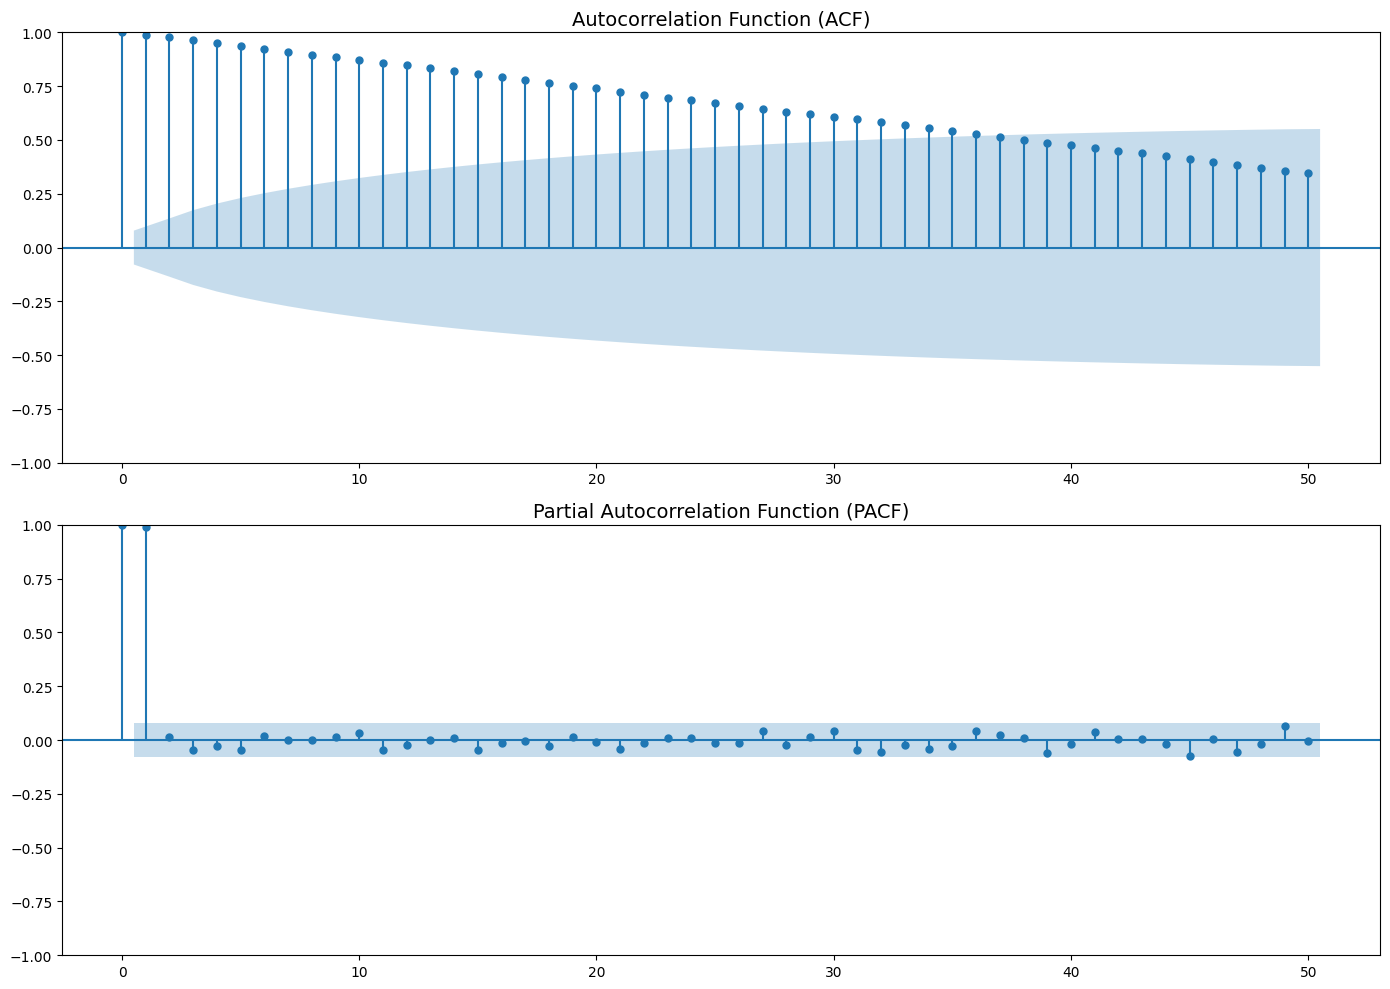

In [1074]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Drop NaNs
series = df2['Close'].dropna()

# Create full-page layout
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot ACF
plot_acf(series, lags=50, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=14)

# Plot PACF
plot_pacf(series, lags=50, ax=axes[1], method='ywm')  # Use yule-walker to avoid warnings
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=14)

plt.tight_layout()
plt.show()

In [1075]:
# make stationary:
df2['diff_close'] = df2['Close'].diff()
df2['seasonal_diff'] = df2['diff_close'] - df2['diff_close'].shift(5)
df2 = df2.dropna()


In [1076]:
from statsmodels.tsa.stattools import adfuller
adfuller(df2['diff_close'])


(np.float64(-25.057973194004596),
 0.0,
 0,
 611,
 {'1%': np.float64(-3.4410979308822967),
  '5%': np.float64(-2.8662819588823423),
  '10%': np.float64(-2.5692953639629166)},
 np.float64(7668.578190605496))

In [1077]:
# cheak again stationary

def check_stationarity_tests(df2, col):
    series = df2[col].dropna()

    # ADF Test
    adf_stat, adf_p, _, _, adf_crit, _ = adfuller(series)
    adf_result = {
        "Test": "ADF",
        "Test Statistic": round(adf_stat, 4),
        "p-value": round(adf_p, 4),
        "Conclusion": "Stationary" if adf_p < 0.05 else "Non-Stationary"
    }

    # KPSS Test
    try:
        kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags='auto')
        kpss_result = {
            "Test": "KPSS",
            "Test Statistic": round(kpss_stat, 4),
            "p-value": round(kpss_p, 4),
            "Conclusion": "Stationary" if kpss_p > 0.05 else "Non-Stationary"
        }
    except Exception as e:
        kpss_result = {
            "Test": "KPSS",
            "Test Statistic": None,
            "p-value": None,
            "Conclusion": f"Error: {str(e)}"
        }

    # KS Test on returns (for normality)
    returns = series.pct_change().dropna()
    ks_stat, ks_p = kstest(returns, 'norm', args=(returns.mean(), returns.std()))
    ks_result = {
        "Test": "KS",
        "Test Statistic": round(ks_stat, 4),
        "p-value": round(ks_p, 4),
        "Conclusion": "Normal" if ks_p > 0.05 else "Not Normal"
    }

    return pd.DataFrame([adf_result, kpss_result, ks_result])
check_stationarity_tests(df2, 'seasonal_diff')




,Test,Test Statistic,p-value,Conclusion
0,ADF,-9.3960,0.0,Stationary
1,KPSS,0.0072,0.1,Stationary
2,KS,0.5130,0.0,Not Normal


In [1078]:
# STL Plot for open price

# STL decomposition
stl = STL(df2['Open'], period=30)
res = stl.fit()

# Extract components
observed = df2['Open']
trend = res.trend
seasonal = res.seasonal
resid = res.resid
dates = df2['Date']

# Create 4-row subplot
fig = make_subplots(
    rows=4, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    subplot_titles=("Observed", "Trend", "Seasonal", "Residual")
)

fig.add_trace(go.Scatter(x=dates, y=observed, name='Observed', line=dict(color='white')), row=1, col=1)
fig.add_trace(go.Scatter(x=dates, y=trend, name='Trend', line=dict(color='orange')), row=2, col=1)
fig.add_trace(go.Scatter(x=dates, y=seasonal, name='Seasonal', line=dict(color='cyan')), row=3, col=1)
fig.add_trace(go.Scatter(x=dates, y=resid, name='Residual', line=dict(color='magenta')), row=4, col=1)

# Layout
fig.update_layout(
    height=900,
    title_text="📈 STL Decomposition of Open Price",
    template='plotly_dark',
    showlegend=False,
    title_x=0.5
)

fig.show()


In [1079]:
# STL Plot for open price

# STL decomposition
stl = STL(df2['Close'], period=30)
res = stl.fit()

# Create subplots
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=4, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    subplot_titles=('Observed', 'Trend', 'Seasonal', 'Residual')
)

fig.add_trace(go.Scatter(y=res.observed, mode='lines', name='Observed', line=dict(color='cyan')), row=1, col=1)
fig.add_trace(go.Scatter(y=res.trend, mode='lines', name='Trend', line=dict(color='orange')), row=2, col=1)
fig.add_trace(go.Scatter(y=res.seasonal, mode='lines', name='Seasonal', line=dict(color='lime')), row=3, col=1)
fig.add_trace(go.Scatter(y=res.resid, mode='lines', name='Residual', line=dict(color='magenta')), row=4, col=1)

fig.update_layout(
    height=900,
    template='plotly_dark',
    title_text='STL Decomposition of Close Price',
    title_x=0.5,
    showlegend=False
)

fig.show()


In [1080]:
# see the seanality strength on defferent values period
for p in [7, 15, 30,45,60,90]:
    stl = STL(df2['seasonal_diff'], period=p)
    res = stl.fit()
    s_strength = 1 - res.resid.var() / (res.resid.var() + res.seasonal.var())
    print(f"Period {p} => Seasonal Strength: {s_strength:.2f}")


Period 7 => Seasonal Strength: 0.33
Period 15 => Seasonal Strength: 0.25
Period 30 => Seasonal Strength: 0.31
Period 45 => Seasonal Strength: 0.31
Period 60 => Seasonal Strength: 0.35
Period 90 => Seasonal Strength: 0.35


In [1081]:
# set the index
df2 = df2.set_index('Date')
df2 = df2.reset_index()

In [1082]:
df2

,Date,Open,High,Low,Close,Volume,diff_close,seasonal_diff
0,2023-01-10,5252.979980,5304.706889,5197.097311,5216.702535,5584,12.271394,-97.929984
1,2023-01-11,5242.468750,5286.079895,5216.116142,5252.980382,2606,36.277847,56.127578
2,2023-01-12,5206.386719,5268.673959,5195.386174,5195.386174,6002,-57.594208,20.289730
3,2023-01-13,5202.670898,5254.838022,5162.971059,5195.239324,6958,-0.146851,13.591237
4,2023-01-16,5246.966797,5254.838107,5187.074941,5203.013317,2457,7.773994,-106.093766
...,...,...,...,...,...,...,...,...
607,2025-06-30,6810.000000,6854.574545,6777.312000,6854.574545,39675,259.523105,536.875889
608,2025-07-01,6788.500000,6869.500000,6750.000000,6835.000000,20934,-19.574545,-267.211151
609,2025-07-02,6653.000000,6785.000000,6609.000000,6752.500000,35382,-82.500000,-82.500182
610,2025-07-03,6765.000000,6800.000000,6650.000000,6700.000000,28832,-52.500000,-48.042570


In [1083]:
# plot box plot for see the close price by open the day of market
import plotly.express as px

# Add day names column
df2['DayOfWeek'] = df2['Date'].dt.day_name()

# Define weekday order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot
fig = px.box(
    df2, x='DayOfWeek', y='Close',
    category_orders={'DayOfWeek': day_order},
    title='📊 Stock Close Price Distribution by Day of Week',
    template='plotly_dark',
    color='DayOfWeek'
)

fig.update_layout(
    title_x=0.5,
    xaxis_title='Day of Week',
    yaxis_title='Close Price',
    showlegend=False
)

fig.show()

In [1084]:
# Trend–Momentum–Timing confirmation Plot

from plotly.subplots import make_subplots

# --- In-Memory Indicator Calculation ---

# EMA
ema20 = df2['Close'].ewm(span=20).mean()
ema50 = df2['Close'].ewm(span=50).mean()

# MACD
ema12 = df2['Close'].ewm(span=12).mean()
ema26 = df2['Close'].ewm(span=26).mean()
macd = ema12 - ema26
signal = macd.ewm(span=9).mean()
macd_hist = macd - signal

# RSI
delta = df2['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

# --- Plotting ---
fig = make_subplots(
    rows=3, cols=1, shared_xaxes=True,
    row_heights=[0.5, 0.25, 0.25],
    subplot_titles=['Candlestick + EMA', 'MACD', 'RSI']
)

# Candlestick + EMA (Row 1)
fig.add_trace(go.Candlestick(
    x=df2['Date'], open=df2['Open'], high=df2['High'],
    low=df2['Low'], close=df2['Close'],
    increasing_line_color='lime', decreasing_line_color='red',
    name='Candles'
), row=1, col=1)

fig.add_trace(go.Scatter(x=df2['Date'], y=ema20, line=dict(color='orange'), name='EMA20'), row=1, col=1)
fig.add_trace(go.Scatter(x=df2['Date'], y=ema50, line=dict(color='cyan'), name='EMA50'), row=1, col=1)

# MACD (Row 2)
fig.add_trace(go.Scatter(x=df2['Date'], y=macd, line=dict(color='white'), name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df2['Date'], y=signal, line=dict(color='orange'), name='Signal'), row=2, col=1)
fig.add_trace(go.Bar(x=df2['Date'], y=macd_hist, marker_color='lightblue', name='Histogram'), row=2, col=1)

# RSI (Row 3)
fig.add_trace(go.Scatter(x=df2['Date'], y=rsi, line=dict(color='magenta'), name='RSI'), row=3, col=1)
fig.add_trace(go.Scatter(x=df2['Date'], y=[70]*len(df), line=dict(color='red', dash='dash'), showlegend=False), row=3, col=1)
fig.add_trace(go.Scatter(x=df2['Date'], y=[30]*len(df), line=dict(color='green', dash='dash'), showlegend=False), row=3, col=1)

# Layout
fig.update_layout(
    template='plotly_dark',
    height=1000,
    title= "Trend–Momentum–Timing confirmation system",
    xaxis_rangeslider_visible=False,
    hovermode='x unified'
)

fig.show()

In [1085]:
# Bollinger–RSI–Volume Confirmation Plot

# --- In-Memory Bollinger Bands Calculation ---
ma20 = df2['Close'].rolling(window=20).mean()
std20 = df2['Close'].rolling(window=20).std()
bb_upper = ma20 + 2 * std20
bb_lower = ma20 - 2 * std20

# --- In-Memory RSI Calculation ---
delta = df2['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

# --- Plotting ---
fig = make_subplots(
    rows=3, cols=1, shared_xaxes=True,
    row_heights=[0.5, 0.2, 0.3],
    subplot_titles=['Candlestick + Bollinger Bands', 'Volume', 'RSI']
)

# Candlestick + Bollinger Bands (Row 1)
fig.add_trace(go.Candlestick(
    x=df2['Date'], open=df2['Open'], high=df2['High'],
    low=df2['Low'], close=df2['Close'],
    increasing_line_color='lime', decreasing_line_color='red',
    name='Candles'
), row=1, col=1)

fig.add_trace(go.Scatter(x=df2['Date'], y=bb_upper, line=dict(color='red', width=1), name='Upper Band'), row=1, col=1)
fig.add_trace(go.Scatter(x=df2['Date'], y=bb_lower, line=dict(color='blue', width=1), name='Lower Band'), row=1, col=1)

# Volume (Row 2)
fig.add_trace(go.Bar(
    x=df2['Date'], y=df2['Volume'],
    marker_color='lightgreen',
    name='Volume'
), row=2, col=1)

# RSI (Row 3)
fig.add_trace(go.Scatter(x=df2['Date'], y=rsi, line=dict(color='magenta'), name='RSI'), row=3, col=1)
fig.add_trace(go.Scatter(x=df2['Date'], y=[70]*len(df2), line=dict(color='red', dash='dash'), showlegend=False), row=3, col=1)
fig.add_trace(go.Scatter(x=df2['Date'], y=[30]*len(df2), line=dict(color='green', dash='dash'), showlegend=False), row=3, col=1)

# Layout
fig.update_layout(
    template='plotly_dark',
    height=900,
    title='Bollinger–RSI–Volume Confirmation',
    xaxis_rangeslider_visible=False,
    hovermode='x unified',
    font=dict(color='white')
)

fig.show()



In [1086]:
# Trend–Volatility–Momentum  Plot

# --- In-memory Calculations ---
# EMA
ema20 = df2['Close'].ewm(span=20).mean()
ema50 = df2['Close'].ewm(span=50).mean()

# Bollinger Bands
ma20 = df2['Close'].rolling(window=20).mean()
std20 = df2['Close'].rolling(window=20).std()
bb_upper = ma20 + 2 * std20
bb_lower = ma20 - 2 * std20

# MACD
ema12 = df2['Close'].ewm(span=12, adjust=False).mean()
ema26 = df2['Close'].ewm(span=26, adjust=False).mean()
macd = ema12 - ema26
signal = macd.ewm(span=9, adjust=False).mean()
macd_hist = macd - signal

# --- Plotting ---
fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True,
    row_heights=[0.6, 0.4],
    subplot_titles=['Candlestick + EMA + Bollinger Bands', 'MACD']
)

# Candlestick + EMA + BB
fig.add_trace(go.Candlestick(
    x=df2['Date'], open=df2['Open'], high=df2['High'],
    low=df2['Low'], close=df2['Close'],
    increasing_line_color='lime', decreasing_line_color='red',
    name='Candles'
), row=1, col=1)

fig.add_trace(go.Scatter(x=df2['Date'], y=ema20, line=dict(color='orange'), name='EMA20'), row=1, col=1)
fig.add_trace(go.Scatter(x=df2['Date'], y=ema50, line=dict(color='cyan'), name='EMA50'), row=1, col=1)
fig.add_trace(go.Scatter(x=df2['Date'], y=bb_upper, line=dict(color='red', width=1), name='Upper BB'), row=1, col=1)
fig.add_trace(go.Scatter(x=df2['Date'], y=bb_lower, line=dict(color='blue', width=1), name='Lower BB'), row=1, col=1)

# MACD
fig.add_trace(go.Scatter(x=df2['Date'], y=macd, line=dict(color='white'), name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df2['Date'], y=signal, line=dict(color='orange'), name='Signal'), row=2, col=1)
fig.add_trace(go.Bar(x=df2['Date'], y=macd_hist, marker_color='lightblue', name='Histogram'), row=2, col=1)

# Layout
fig.update_layout(
    template='plotly_dark',
    height=800,
    title='Trend–Volatility–Momentum ',
    xaxis_rangeslider_visible=False,
    hovermode='x unified',
    font=dict(color='white')
)
fig.show()

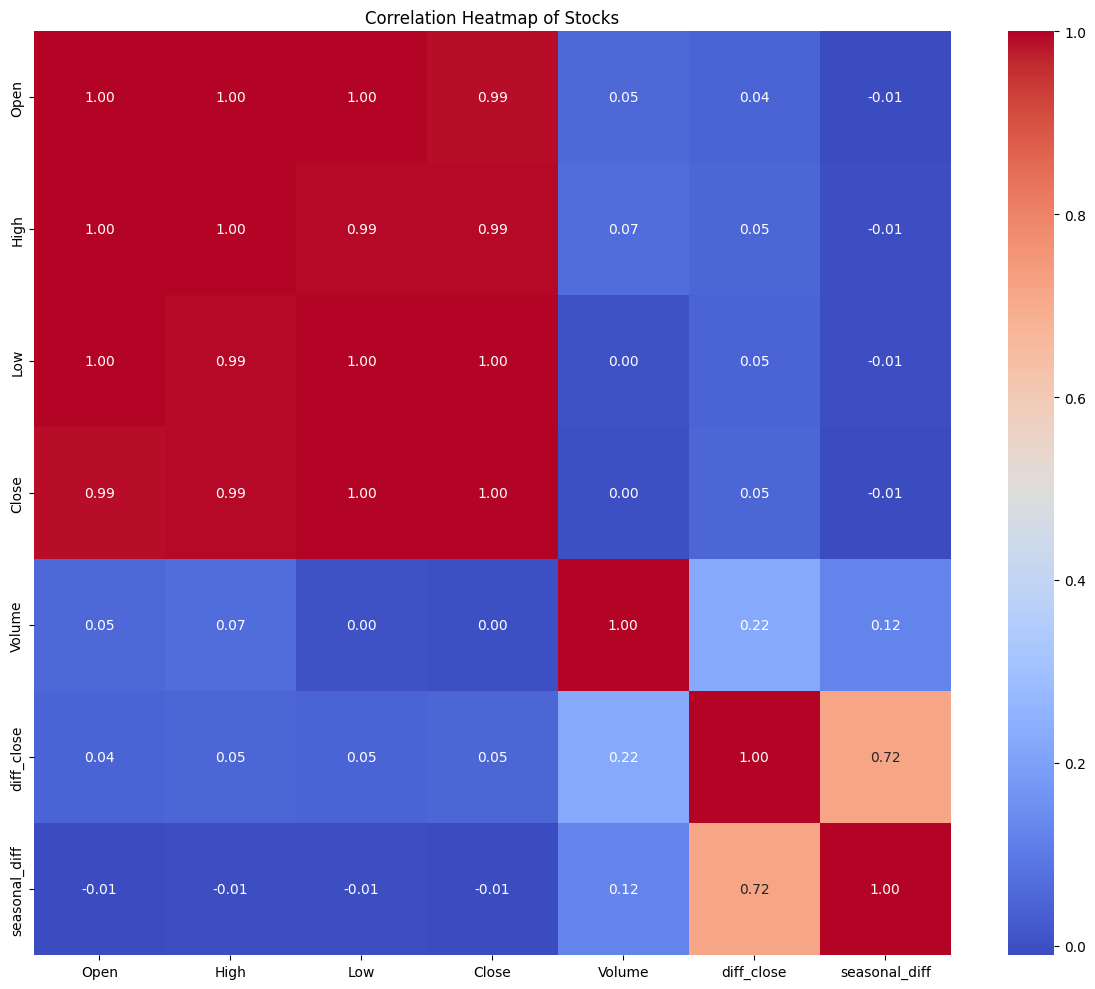

In [1087]:
# corr. matrix plot
correlation = df2.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Stocks")
plt.tight_layout()
plt.show()

In [1088]:
## Arima model fit

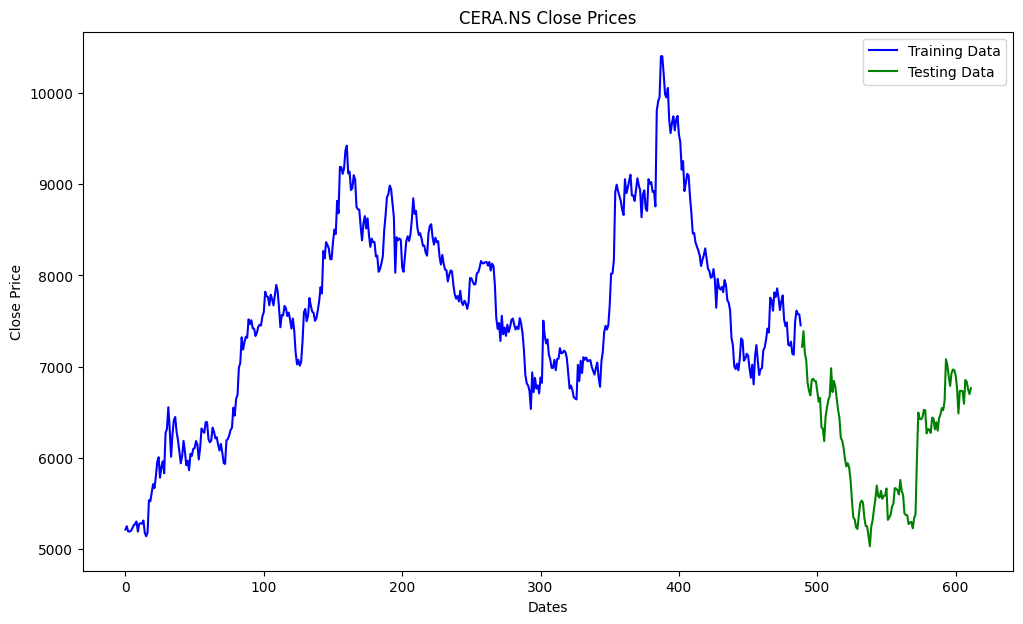

In [1089]:
import matplotlib.pyplot as plt

# Train-test split (80% train, 20% test) on Close price
train_data = df2['Close'].iloc[:int(len(df2) * 0.8)]
test_data = df2['Close'].iloc[int(len(df2) * 0.8):]

# Plot
plt.figure(figsize=(12, 7))
plt.title(f'{stock[0]} Close Prices')
plt.xlabel('Dates')
plt.ylabel('Close Price')
plt.plot(train_data.index, train_data, color='blue', label='Training Data')
plt.plot(test_data.index, test_data, color='green', label='Testing Data')
plt.legend()
plt.show()


In [1090]:
df2['Date'] = pd.to_datetime(df2['Date'])  # convert date column to datetime
df2.set_index('Date', inplace=True)       # set as datetime index


In [1091]:

n_days_forecast = 10      # Forecast horizon
order = (1, 1, 1)         # ARIMA order (p, d, q)
train_ratio = 0.8         # % of data for training

# -----------------------------
# Train-Test Split for Backtesting
# -----------------------------
train_size = int(len(df2) * train_ratio)
train_data = df2['Close'][:train_size]
test_data = df2['Close'][train_size:]

In [1092]:

# -----------------------------
# Walk-forward backtesting for ARIMA
# -----------------------------
history = list(train_data.values)
predictions = []

for t in range(len(test_data)):
    # Fit ARIMA model on history
    model = ARIMA(history, order=order)
    model_fit = model.fit()

    # Forecast next value
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)

    # Append actual observation to history
    history.append(test_data.iloc[t])

# -----------------------------
# Backtesting metrics
# -----------------------------
mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)
mape = np.mean(np.abs((test_data - predictions)/test_data)) * 100
smape = 100 * np.mean(2 * np.abs(test_data - predictions) / (np.abs(test_data) + np.abs(predictions)))
r2 = r2_score(test_data, predictions)

# Direction accuracy
direction_true = np.sign(np.diff(test_data))
direction_pred = np.sign(np.diff(predictions))
hit_rate = np.mean(direction_true == direction_pred) * 100

print(f"MSE: {mse:.3f}, RMSE: {rmse:.3f}, MAE: {mae:.3f}")
print(f"MAPE: {mape:.2f}%, SMAPE: {smape:.2f}%, R²: {r2:.3f}")
print(f"Direction accuracy: {hit_rate:.2f}%")


MSE: 22255.505, RMSE: 149.183, MAE: 108.581
MAPE: 1.76%, SMAPE: 1.76%, R²: 0.942
Direction accuracy: 58.20%


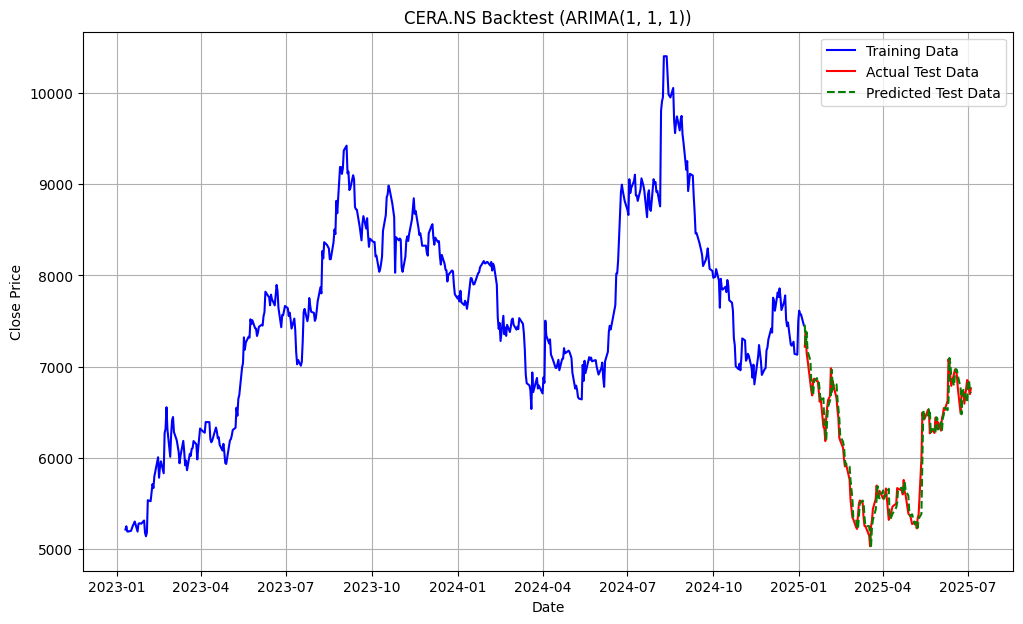

In [1093]:
# Plot backtesting results
# -----------------------------
plt.figure(figsize=(12, 7))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Actual Test Data', color='red')
plt.plot(test_data.index, predictions, label='Predicted Test Data', color='green', linestyle='dashed')
plt.title(f"{stock[0]} Backtest (ARIMA{order})")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [1094]:
# -----------------------------
# Final Forecast (n days ahead)
# -----------------------------
model_final = ARIMA(df2['Close'].values, order=order)
model_final_fit = model_final.fit()

forecast_obj = model_final_fit.get_forecast(steps=n_days_forecast)
forecast_mean = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int(alpha=0.05)

# Future business days
last_date = df2.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_days_forecast, freq='B')

forecast_df2 = pd.DataFrame({
    'Date': future_dates,
    'Forecasted_Close': forecast_mean,
    'Lower_Bound': conf_int[:, 0],
    'Upper_Bound': conf_int[:, 1]
}).set_index('Date')

print("\nForecast:")
print(forecast_df2)


Forecast:
            Forecasted_Close  Lower_Bound  Upper_Bound
Date                                                  
2025-07-07       6753.310644  6449.535301  7057.085988
2025-07-08       6763.780873  6339.834248  7187.727497
2025-07-09       6754.402624  6233.345438  7275.459811
2025-07-10       6762.802779  6163.305147  7362.300412
2025-07-11       6755.278709  6083.892509  7426.664908
2025-07-14       6762.018065  6027.841983  7496.194147
2025-07-15       6755.981582  5962.224696  7549.738467
2025-07-16       6761.388497  5913.689821  7609.087174
2025-07-17       6756.545490  5856.897248  7656.193732
2025-07-18       6760.883402  5813.180188  7708.586615


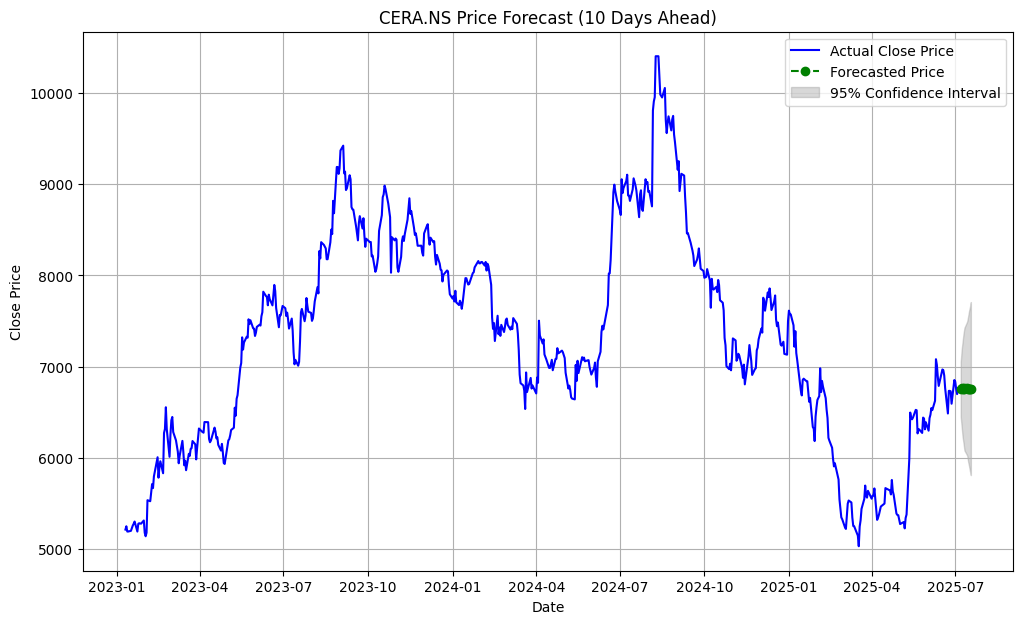

In [1095]:
# -----------------------------
# Plot forecast
# -----------------------------
plt.figure(figsize=(12, 7))
plt.plot(df2.index, df2['Close'], color='blue', label='Actual Close Price')
plt.plot(forecast_df2.index, forecast_df2['Forecasted_Close'], color='green', marker='o', linestyle='dashed', label='Forecasted Price')
plt.fill_between(forecast_df2.index, forecast_df2['Lower_Bound'], forecast_df2['Upper_Bound'], color='gray', alpha=0.3, label='95% Confidence Interval')
plt.title(f'{stock[0]} Price Forecast ({n_days_forecast} Days Ahead)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

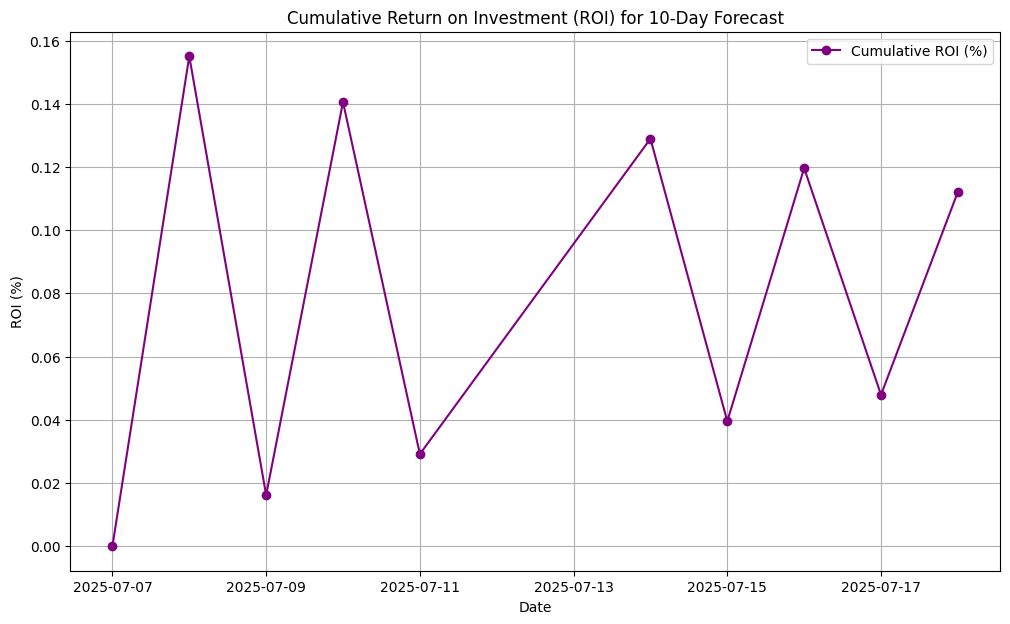

In [1096]:

# 1. Calculate daily returns (%) from forecasted prices
forecast_df2['Daily_Return_%'] = forecast_df2['Forecasted_Close'].pct_change().fillna(0) * 100

forecast_df2['Cumulative_ROI_%'] = (forecast_df2['Forecasted_Close'] / forecast_df2['Forecasted_Close'].iloc[0] - 1) * 100

# 3. Plot cumulative ROI over forecast horizon
plt.figure(figsize=(12, 7))
plt.plot(forecast_df2.index, forecast_df2['Cumulative_ROI_%'], marker='o', color='purple', label='Cumulative ROI (%)')
plt.title(f'Cumulative Return on Investment (ROI) for {n_days_forecast}-Day Forecast')
plt.xlabel('Date')
plt.ylabel('ROI (%)')
plt.grid(True)
plt.legend()
plt.show()


In [1097]:
#SARIMA:

In [1098]:

# -----------------------------
# Parameters
# -----------------------------
n_days_forecast = 10        # Forecast horizon
order = (2, 1, 2)           # (p,d,q) for ARIMA part
seasonal_order = (1, 1, 1, 5)  # (P,D,Q,s) for seasonal part
train_ratio = 0.8           # Train-test split ratio

In [1099]:
# -----------------------------
# Train-Test Split for Backtesting
# -----------------------------
train_size = int(len(df2) * train_ratio)
train_data = df2['Close'][:train_size]
test_data = df2['Close'][train_size:]

In [1100]:

history = list(train_data.values)
predictions = []

for t in range(len(test_data)):
    model = SARIMAX(history, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)

    yhat = model_fit.forecast(steps=1)[0]
    predictions.append(yhat)
    history.append(test_data.iloc[t])

# Metrics
mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)
mape = np.mean(np.abs((test_data - predictions)/test_data)) * 100
smape = 100 * np.mean(2 * np.abs(test_data - predictions) / (np.abs(test_data) + np.abs(predictions)))
r2 = r2_score(test_data, predictions)

# Direction accuracy
direction_true = np.sign(np.diff(test_data))
direction_pred = np.sign(np.diff(predictions))
hit_rate = np.mean(direction_true == direction_pred) * 100

print(f"MSE: {mse:.3f}, RMSE: {rmse:.3f}, MAE: {mae:.3f}")
print(f"MAPE: {mape:.2f}%, SMAPE: {smape:.2f}%, R²: {r2:.3f}")
print(f"Direction accuracy: {hit_rate:.2f}%")



MSE: 22823.130, RMSE: 151.073, MAE: 110.096
MAPE: 1.78%, SMAPE: 1.78%, R²: 0.941
Direction accuracy: 55.74%


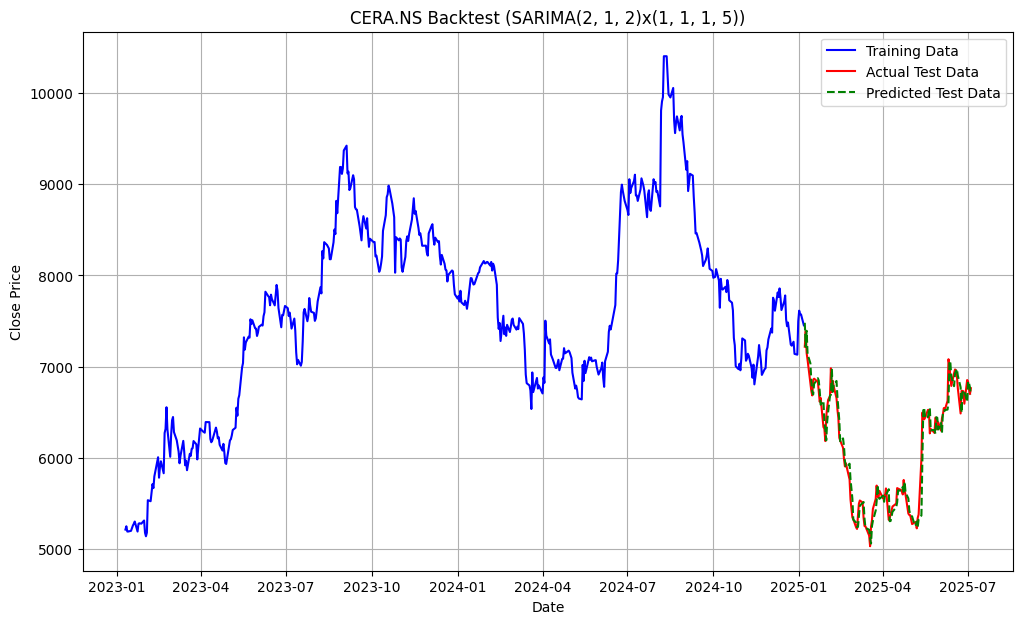

In [1101]:
# -----------------------------
# Plot backtesting results
# -----------------------------
plt.figure(figsize=(12, 7))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Actual Test Data', color='red')
plt.plot(test_data.index, predictions, label='Predicted Test Data', color='green', linestyle='dashed')
plt.title(f"{stock[0]} Backtest (SARIMA{order}x{seasonal_order})")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

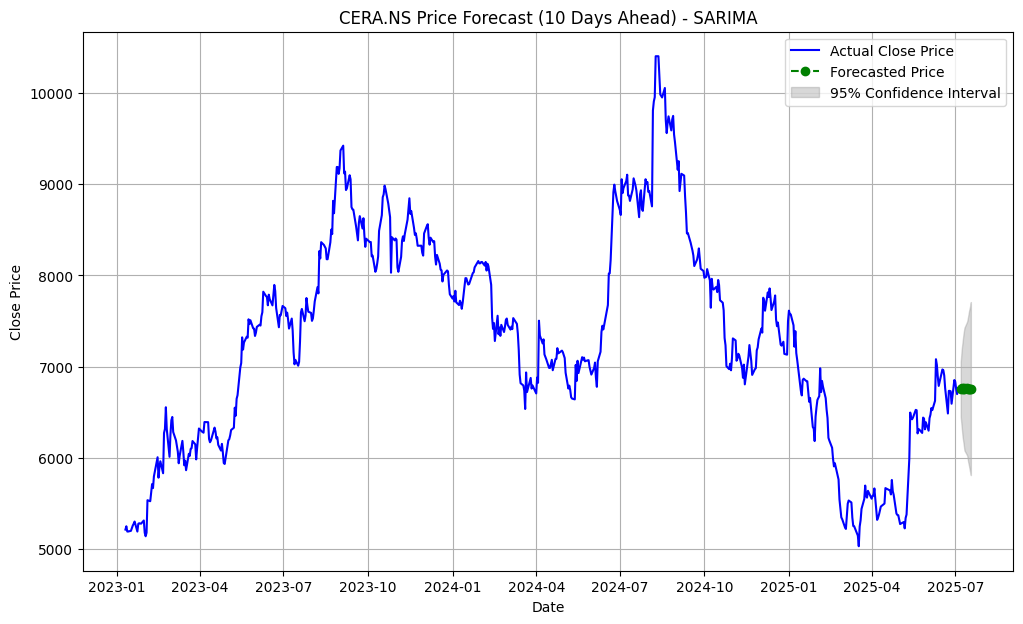

In [1102]:
# Plot forecast
# -----------------------------
plt.figure(figsize=(12, 7))
plt.plot(df2.index, df2['Close'], color='blue', label='Actual Close Price')
plt.plot(forecast_df2.index, forecast_df2['Forecasted_Close'], color='green', marker='o', linestyle='dashed', label='Forecasted Price')
plt.fill_between(forecast_df2.index, forecast_df2['Lower_Bound'], forecast_df2['Upper_Bound'], color='gray', alpha=0.3, label='95% Confidence Interval')
plt.title(f'{stock[0]} Price Forecast ({n_days_forecast} Days Ahead) - SARIMA')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

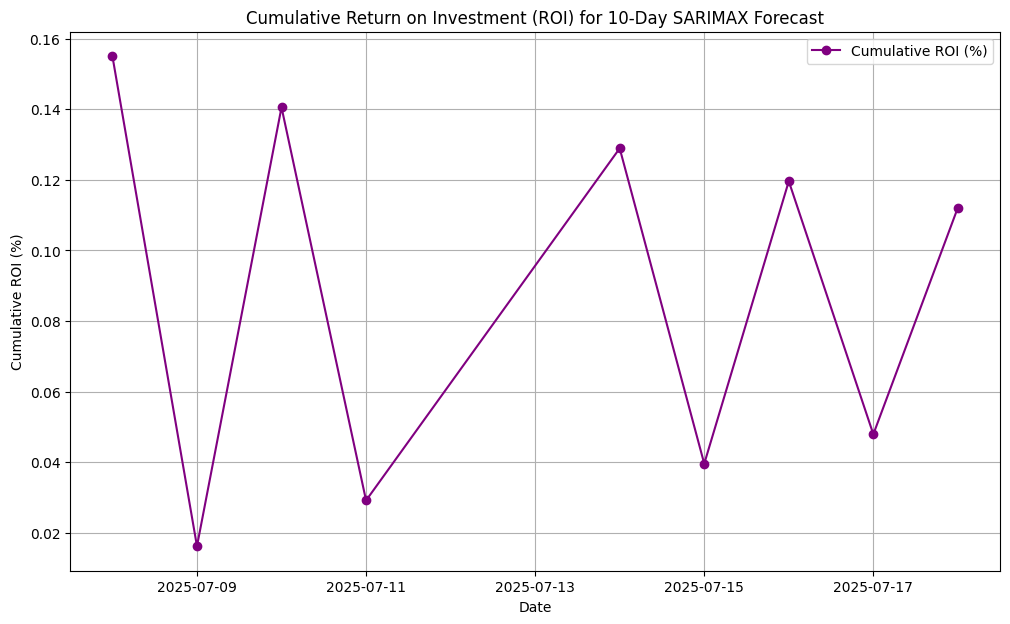

In [1103]:
import matplotlib.pyplot as plt

# Calculate daily returns
forecast_df2['Daily_Return'] = forecast_df2['Forecasted_Close'].pct_change()

# Calculate cumulative ROI (%)
forecast_df2['Cumulative_ROI_%'] = ((1 + forecast_df2['Daily_Return']).cumprod() - 1) * 100

# Fill NaN for clean plotting
forecast_df2['Daily_Return'].fillna(0, inplace=True)

# Plot Cumulative ROI (%) over forecast horizon
plt.figure(figsize=(12, 7))
plt.plot(forecast_df2.index, forecast_df2['Cumulative_ROI_%'],
         marker='o', color='purple', label='Cumulative ROI (%)')

plt.title(f'Cumulative Return on Investment (ROI) for {n_days_forecast}-Day SARIMAX Forecast')
plt.xlabel('Date')
plt.ylabel('Cumulative ROI (%)')
plt.grid(True)
plt.legend()
plt.show()


In [1104]:
# LSTM Model :

In [1105]:
# Feature Engenering:

In [1106]:
# Lag Features
df2['Close_Lag1'] = df2['Close'].shift(1)
df2['Close_Lag2'] = df2['Close'].shift(2)

# Return Features
df2['Close_Return1'] = df2['Close'].pct_change(1)
df2['Close_Return2'] = df2['Close'].pct_change(2)

# Moving Averages
df2['MA10'] = df2['Close'].rolling(window=10).mean()
df2['MA30'] = df2['Close'].rolling(window=30).mean()

 # EMA
df2['EMA_12'] = df2['Close'].ewm(span=12, adjust=False).mean()
df2['EMA_26'] = df2['Close'].ewm(span=26, adjust=False).mean()

 # RSI
delta = df2['Close'].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)

# Flatten the arrays before creating Series
avg_gain = pd.Series(gain.flatten()).rolling(window=14).mean()
avg_loss = pd.Series(loss.flatten()).rolling(window=14).mean()
rs = avg_gain / avg_loss
df2['RSI_14'] = 100 - (100 / (1 + rs))

# MACD
ema_fast = df2['Close'].ewm(span=12, adjust=False).mean()
ema_slow = df2['Close'].ewm(span=26, adjust=False).mean()
df2['MACD'] = ema_fast - ema_slow
df2['MACD_Signal'] = df2['MACD'].ewm(span=9, adjust=False).mean()
df2['MACD_Hist'] = df2['MACD'] - df2['MACD_Signal']

# Bollinger Bands
df2['BB_MA20'] = df2['Close'].rolling(window=20).mean()
std = df2['Close'].rolling(window=20).std()
df2['BB_Upper'] = df2['BB_MA20'] + 2 * std
df2['BB_Lower'] = df2['BB_MA20'] - 2 * std
df2['BB_Width'] = df2['BB_Upper'] - df2['BB_Lower']



# Volume-based
df2['Volume_pct_change'] = df2['Volume'].pct_change()
df2['Volume_MA10'] = df2['Volume'].rolling(window=10).mean()
df2['Volume_STD10'] = df2['Volume'].rolling(window=10).std()



In [1107]:
# drop the non numeric columns
df2.drop(columns=['DayOfWeek','RSI_14'], inplace=True)


In [1108]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 612 entries, 2023-01-10 to 2025-07-04
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               612 non-null    float64
 1   High               612 non-null    float64
 2   Low                612 non-null    float64
 3   Close              612 non-null    float64
 4   Volume             612 non-null    int64  
 5   diff_close         612 non-null    float64
 6   seasonal_diff      612 non-null    float64
 7   Close_Lag1         611 non-null    float64
 8   Close_Lag2         610 non-null    float64
 9   Close_Return1      611 non-null    float64
 10  Close_Return2      610 non-null    float64
 11  MA10               603 non-null    float64
 12  MA30               583 non-null    float64
 13  EMA_12             612 non-null    float64
 14  EMA_26             612 non-null    float64
 15  MACD               612 non-null    float64
 16  MACD_Si

In [1109]:


missing_percent = df2.isnull().mean() * 100
print("Percentage of missing values per column:")
print(missing_percent.sort_values(ascending=False))

# Drop columns with more than 20% missing values for example
cols_to_drop_missing = missing_percent[missing_percent > 20].index.tolist()
print(f"Columns to drop due to missing data >20%: {cols_to_drop_missing}")

Percentage of missing values per column:
MA30                 4.738562
BB_MA20              3.104575
BB_Upper             3.104575
BB_Lower             3.104575
BB_Width             3.104575
Volume_STD10         1.470588
Volume_MA10          1.470588
MA10                 1.470588
Close_Lag2           0.326797
Close_Return2        0.326797
Close_Return1        0.163399
Volume_pct_change    0.163399
Close_Lag1           0.163399
Low                  0.000000
High                 0.000000
Open                 0.000000
Volume               0.000000
diff_close           0.000000
seasonal_diff        0.000000
Close                0.000000
EMA_12               0.000000
MACD_Signal          0.000000
MACD                 0.000000
EMA_26               0.000000
MACD_Hist            0.000000
dtype: float64
Columns to drop due to missing data >20%: []


In [1110]:
# Impute remaining missing values with forward fill (and backward fill as fallback)
df2= df2.fillna(method='ffill').fillna(method='bfill')

# Verify no more missing values remain
print(df2.isnull().sum())

Open                 0
High                 0
Low                  0
Close                0
Volume               0
diff_close           0
seasonal_diff        0
Close_Lag1           0
Close_Lag2           0
Close_Return1        0
Close_Return2        0
MA10                 0
MA30                 0
EMA_12               0
EMA_26               0
MACD                 0
MACD_Signal          0
MACD_Hist            0
BB_MA20              0
BB_Upper             0
BB_Lower             0
BB_Width             0
Volume_pct_change    0
Volume_MA10          0
Volume_STD10         0
dtype: int64


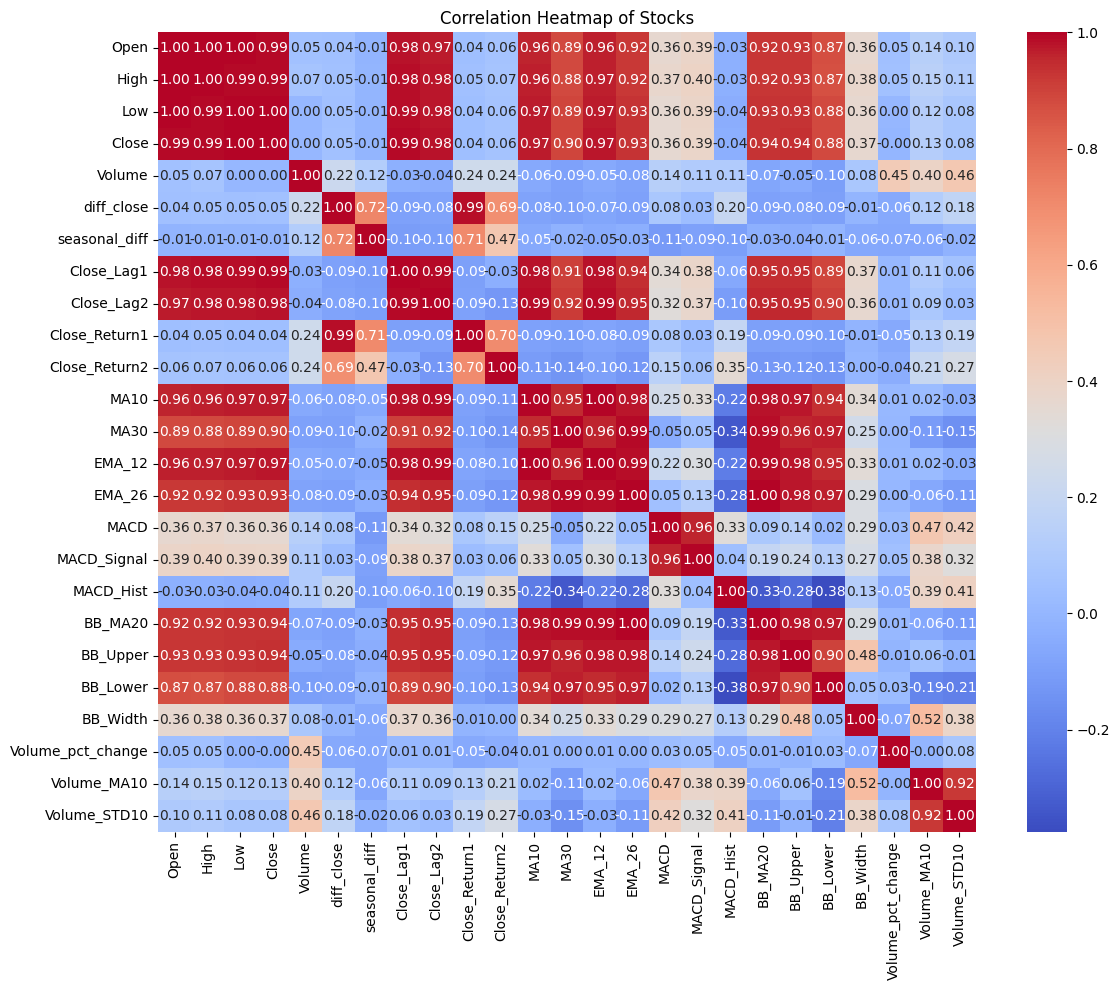

In [1111]:
# Plot the corr plot to see tha corr  with each other columns
correlation = df2.corr(numeric_only=True)
# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Stocks")
plt.tight_layout()
plt.show()


In [1112]:
df2.head()

,Open,High,Low,Close,Volume,diff_close,seasonal_diff,Close_Lag1,Close_Lag2,Close_Return1,...,MACD,MACD_Signal,MACD_Hist,BB_MA20,BB_Upper,BB_Lower,BB_Width,Volume_pct_change,Volume_MA10,Volume_STD10
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-10,5252.979980,5304.706889,5197.097311,5216.702535,5584,12.271394,-97.929984,5216.702535,5216.702535,0.006954,...,0.000000,0.000000,0.000000,5284.700565,5543.959569,5025.44156,518.518009,-0.533309,6288.4,5562.360834
2023-01-11,5242.468750,5286.079895,5216.116142,5252.980382,2606,36.277847,56.127578,5216.702535,5216.702535,0.006954,...,2.893959,0.578792,2.315167,5284.700565,5543.959569,5025.44156,518.518009,-0.533309,6288.4,5562.360834
2023-01-12,5206.386719,5268.673959,5195.386174,5195.386174,6002,-57.594208,20.289730,5252.980382,5216.702535,-0.010964,...,0.533917,0.569817,-0.035900,5284.700565,5543.959569,5025.44156,518.518009,1.303147,6288.4,5562.360834
2023-01-13,5202.670898,5254.838022,5162.971059,5195.239324,6958,-0.146851,13.591237,5195.386174,5252.980382,-0.000028,...,-1.332918,0.189270,-1.522188,5284.700565,5543.959569,5025.44156,518.518009,0.159280,6288.4,5562.360834
2023-01-16,5246.966797,5254.838107,5187.074941,5203.013317,2457,7.773994,-106.093766,5195.239324,5195.386174,0.001496,...,-2.160200,-0.280624,-1.879576,5284.700565,5543.959569,5025.44156,518.518009,-0.646881,6288.4,5562.360834


In [1113]:
#LSTM

In [1114]:
# If your df2 has a 'Date' column (not index), make it the index
if not isinstance(df2.index, pd.DatetimeIndex) and 'Date' in df2.columns:
    df2 = df2.set_index(pd.to_datetime(df2['Date'])).drop(columns=['Date'])

df2 = df2.sort_index()

# Keep only numeric columns
data = df2.select_dtypes(include=np.number).copy()

# Drop NaNs/infs
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

In [1115]:
# ===================== 2) Scale Data =====================
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.values)
close_idx = data.columns.get_loc('Close')

# Helper for inverse scaling Close only
inv_close = lambda x: x * (scaler.data_max_[close_idx] - scaler.data_min_[close_idx]) + scaler.data_min_[close_idx]

In [1116]:
# ===================== 3) Create Dataset =====================
time_steps = 60
X, y = [], []
for i in range(time_steps, len(scaled_data)):
    X.append(scaled_data[i-time_steps:i])
    y.append(scaled_data[i, close_idx])
X, y = np.array(X), np.array(y)

In [1117]:
# ===================== 4) Train/Test Split =====================
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
train_idx = data.index[time_steps:train_size+time_steps]
test_idx  = data.index[train_size+time_steps:]

In [1118]:
# ===================== 5) Build Model =====================
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, X.shape[2])),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# ===================== 6) Train Model =====================
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.1901 - val_loss: 0.0046
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0218 - val_loss: 0.0143
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0093 - val_loss: 0.0036
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0065 - val_loss: 0.0052
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0054 - val_loss: 0.0045
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0032 - val_loss: 0.0040
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0

In [1119]:
# ===================== 8) Forecast Future =====================
n_days = 10
forecast_in = scaled_data[-time_steps:].reshape(1, time_steps, scaled_data.shape[1])
forecast_scaled = []

for i in range(n_days):
    next_scaled = model.predict(forecast_in)[0, 0]
    forecast_scaled.append(next_scaled)
    last_row = forecast_in[0, -1, :].copy()
    last_row[close_idx] = next_scaled
    forecast_in = np.append(forecast_in[:, 1:, :], last_row.reshape(1, 1, -1), axis=1)

forecast_values = inv_close(np.array(forecast_scaled))
forecast_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=n_days, freq='B')
forecast_df = pd.DataFrame({'Forecasted_Close': forecast_values}, index=forecast_dates)




1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


In [1120]:
# ===================== 7) Predictions on Test =====================
y_pred_test_scaled = model.predict(X_test).flatten()
y_pred_test = inv_close(y_pred_test_scaled)
y_test_inv = inv_close(y_test)

rmse = sqrt(mean_squared_error(y_test_inv, y_pred_test))
print(f"Test RMSE: {rmse:.3f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Test RMSE: 361.148


In [1121]:
# ===================== 9) ROI Calculations =====================
last_actual_price = data['Close'].iloc[-1]
forecast_df['Daily_ROI_%'] = forecast_df['Forecasted_Close'].pct_change().fillna(0) * 100
forecast_df['Cumulative_ROI_%'] = (forecast_df['Forecasted_Close'] / last_actual_price - 1) * 100

print(forecast_df.round(2))

            Forecasted_Close  Daily_ROI_%  Cumulative_ROI_%
2025-07-07           6798.34         0.00              0.49
2025-07-08           6796.81        -0.02              0.47
2025-07-09           6796.64        -0.00              0.47
2025-07-10           6797.89         0.02              0.49
2025-07-11           6800.27         0.04              0.52
2025-07-14           6803.42         0.05              0.57
2025-07-15           6806.98         0.05              0.62
2025-07-16           6810.70         0.05              0.68
2025-07-17           6814.35         0.05              0.73
2025-07-18           6817.83         0.05              0.78


In [1122]:
# =====================  Plot Forecasted Close price  =====================
fig_forecast = go.Figure()
fig_forecast.add_trace(go.Scatter(
    x=forecast_df.index, y=forecast_df['Forecasted_Close'],
    mode='lines+markers', name='Forecast',
    line=dict(color='cyan', width=2)
))
fig_forecast.update_layout(
    title=f'{n_days}-Day Forecasted Close (LSTM)',
    xaxis_title='Date', yaxis_title='Price',
    plot_bgcolor='black', paper_bgcolor='black',
    font=dict(color='white', size=14)
)
fig_forecast.show()


In [1123]:
# =====================  Plot Forecasted ROI %  =====================
fig_roi = go.Figure()
fig_roi.add_trace(go.Scatter(
    x=forecast_df.index, y=forecast_df['Cumulative_ROI_%'],
    mode='lines+markers', name='Cumulative ROI (%)',
    line=dict(color='yellow', width=2)
))
fig_roi.update_layout(
    title=f'{n_days}-Day Forecasted Cumulative ROI',
    xaxis_title='Date', yaxis_title='ROI (%)',
    plot_bgcolor='black', paper_bgcolor='black',
    font=dict(color='white', size=14)
)
fig_roi.show()


In [1124]:
# =====================  Plot : Train vs Test vs Forecast (LSTM)  =====================

y_train_inv = inv_close(y_train)

fig_combined = go.Figure()
fig_combined.add_trace(go.Scatter(
    x=train_idx, y=y_train_inv, mode='lines', name='Training',
    line=dict(color='deepskyblue', width=2)
))
fig_combined.add_trace(go.Scatter(
    x=test_idx, y=y_test_inv, mode='lines', name='Actual Test',
    line=dict(color='white', width=2)
))
fig_combined.add_trace(go.Scatter(
    x=test_idx, y=y_pred_test, mode='lines', name='Predicted Test',
    line=dict(color='red', dash='dash', width=2)
))
fig_combined.add_trace(go.Scatter(
    x=forecast_df.index, y=forecast_df['Forecasted_Close'],
    mode='lines+markers', name='Forecast',
    line=dict(color='lime', dash='dash', width=2)
))
fig_combined.update_layout(
    title='Close: Train vs Test vs Forecast (LSTM)',
    xaxis_title='Date', yaxis_title='Price',
    plot_bgcolor='black', paper_bgcolor='black',
    font=dict(color='white', size=14)
)
fig_combined.show()
